In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/english-premier-league-epl-match-data-2000-2025/epl_final.csv


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data 
df = pd.read_csv('/kaggle/input/english-premier-league-epl-match-data-2000-2025/epl_final.csv')
df.head()

,Season,MatchDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,...,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
0,2000/01,2000-08-19,Charlton,Man City,4,0,H,2,0,H,...,14,4,6,6,13,12,1,2,0,0
1,2000/01,2000-08-19,Chelsea,West Ham,4,2,H,1,0,H,...,10,5,7,7,19,14,1,2,0,0
2,2000/01,2000-08-19,Coventry,Middlesbrough,1,3,A,1,1,D,...,3,9,8,4,15,21,5,3,1,0
3,2000/01,2000-08-19,Derby,Southampton,2,2,D,1,2,A,...,4,6,5,8,11,13,1,1,0,0
4,2000/01,2000-08-19,Leeds,Everton,2,0,H,2,0,H,...,8,6,6,4,21,20,1,3,0,0


## 1. Initial EDA

In [8]:
# Set plotting style
plt.style.use('seaborn')
sns.set_palette('viridis')

In [4]:
# 1. Basic Data Overview
print("Dataset Shape:", df.shape)
print("\nColumn Data Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (9380, 22)

Column Data Types:
 Season               object
MatchDate            object
HomeTeam             object
AwayTeam             object
FullTimeHomeGoals     int64
FullTimeAwayGoals     int64
FullTimeResult       object
HalfTimeHomeGoals     int64
HalfTimeAwayGoals     int64
HalfTimeResult       object
HomeShots             int64
AwayShots             int64
HomeShotsOnTarget     int64
AwayShotsOnTarget     int64
HomeCorners           int64
AwayCorners           int64
HomeFouls             int64
AwayFouls             int64
HomeYellowCards       int64
AwayYellowCards       int64
HomeRedCards          int64
AwayRedCards          int64
dtype: object

Missing Values:
 Season               0
MatchDate            0
HomeTeam             0
AwayTeam             0
FullTimeHomeGoals    0
FullTimeAwayGoals    0
FullTimeResult       0
HalfTimeHomeGoals    0
HalfTimeAwayGoals    0
HalfTimeResult       0
HomeShots            0
AwayShots            0
HomeShotsOnTarget    0
AwaySh

In [5]:
# 2. Convert MatchDate to datetime
df['MatchDate'] = pd.to_datetime(df['MatchDate'], format='%Y-%m-%d')

In [9]:
# 3. Summary Statistics for Numerical Columns
numerical_cols = ['FullTimeHomeGoals', 'FullTimeAwayGoals', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals',
                  'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
                  'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
                  'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards']
print("\nSummary Statistics for Numerical Columns:\n", df[numerical_cols].describe())


Summary Statistics for Numerical Columns:
        FullTimeHomeGoals  FullTimeAwayGoals  HalfTimeHomeGoals  \
count        9380.000000        9380.000000        9380.000000   
mean            1.535394           1.182623           0.688273   
std             1.305432           1.157414           0.835079   
min             0.000000           0.000000           0.000000   
25%             1.000000           0.000000           0.000000   
50%             1.000000           1.000000           0.000000   
75%             2.000000           2.000000           1.000000   
max             9.000000           9.000000           5.000000   

       HalfTimeAwayGoals    HomeShots    AwayShots  HomeShotsOnTarget  \
count        9380.000000  9380.000000  9380.000000        9380.000000   
mean            0.518763    13.617484    10.810661           5.973134   
std             0.735357     5.356424     4.696501           3.267954   
min             0.000000     0.000000     0.000000           0.000000

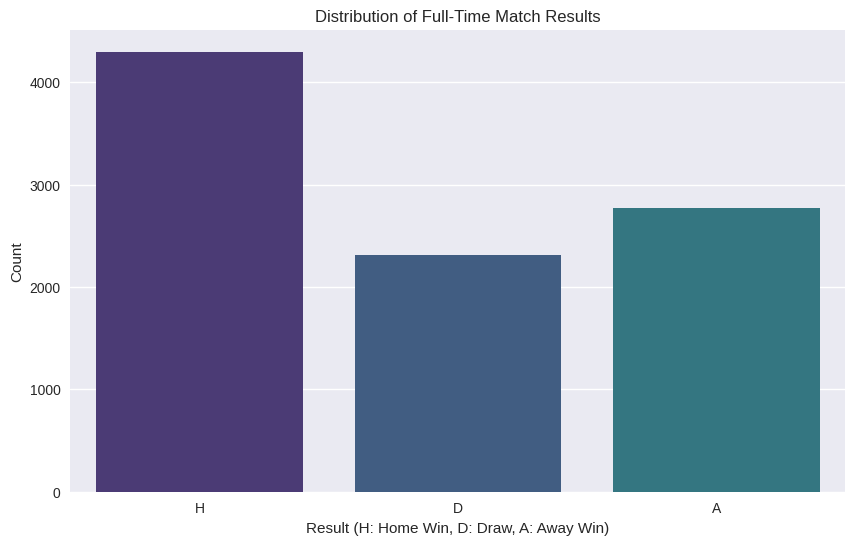

In [10]:
# 4. Distribution of Match Results
plt.figure(figsize=(10, 6))
sns.countplot(x='FullTimeResult', data=df, order=['H', 'D', 'A'])
plt.title('Distribution of Full-Time Match Results')
plt.xlabel('Result (H: Home Win, D: Draw, A: Away Win)')
plt.ylabel('Count')
plt.show()

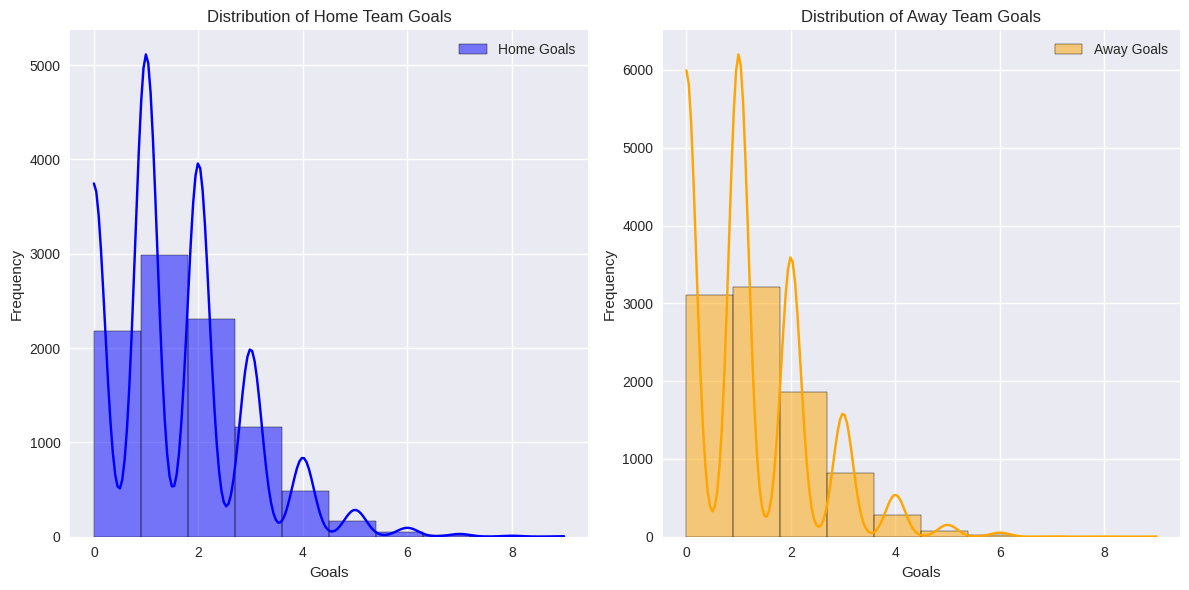

In [11]:
# 5. Goals Distribution (Home vs Away)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['FullTimeHomeGoals'], bins=10, kde=True, color='blue', label='Home Goals')
plt.title('Distribution of Home Team Goals')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df['FullTimeAwayGoals'], bins=10, kde=True, color='orange', label='Away Goals')
plt.title('Distribution of Away Team Goals')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

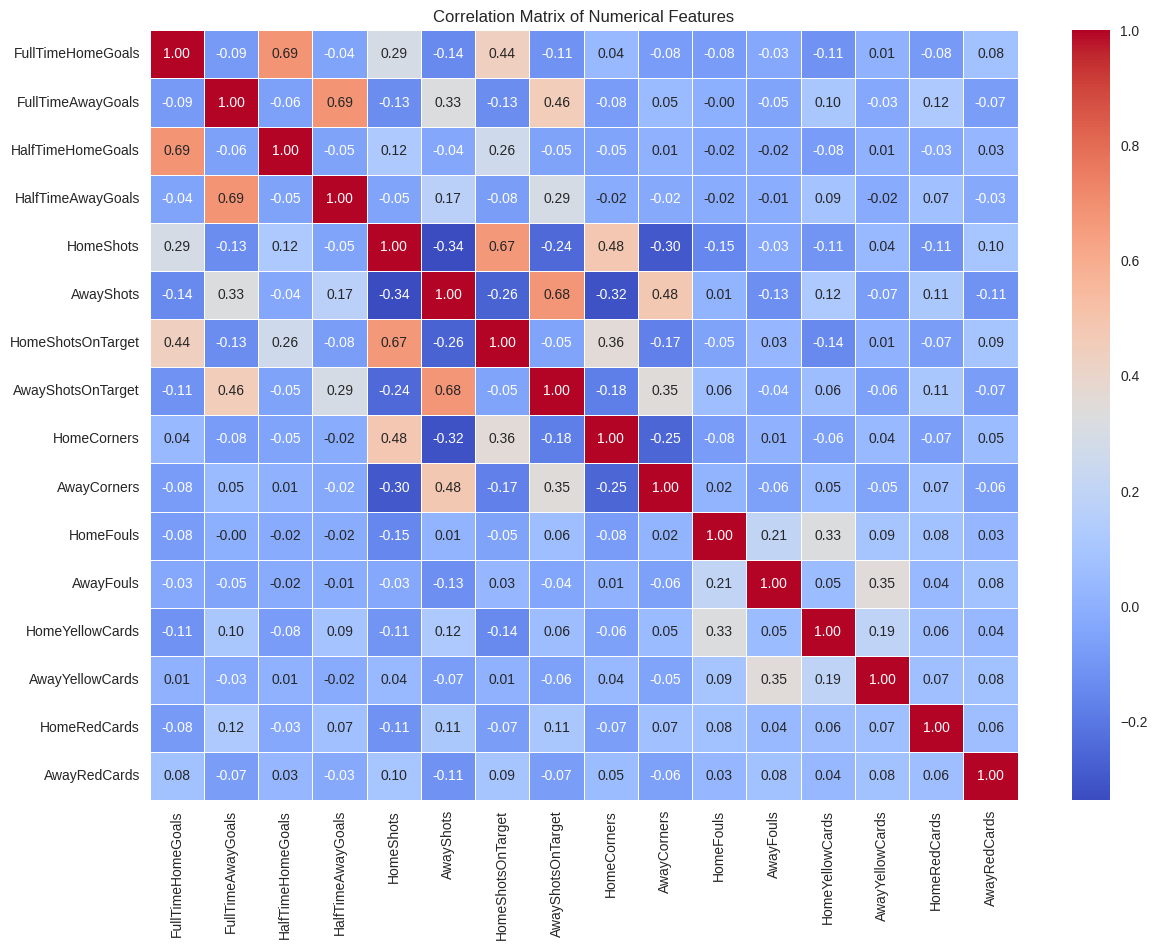

In [12]:
# 6. Correlation Matrix for Numerical Features
plt.figure(figsize=(14, 10))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [13]:
# 7. Unique Teams and Seasons
print("\nUnique Seasons:", df['Season'].nunique())
print("Unique Home Teams:", df['HomeTeam'].nunique())
print("Unique Away Teams:", df['AwayTeam'].nunique())
print("\nSample of Seasons:\n", df['Season'].unique()[:5])


Unique Seasons: 25
Unique Home Teams: 46
Unique Away Teams: 46

Sample of Seasons:
 ['2000/01' '2001/02' '2002/03' '2003/04' '2004/05']


#### **Analysis of Results**

**1. Summary Statistics:**

- **Goals:**
    - FullTimeHomeGoals (mean: 1.54, std: 1.31) higher than FullTimeAwayGoals (mean: 1.18, std: 1.16), suggests a potential home advantage in scoring.
    - Half-time goals follow a similar trend (HalfTimeHomeGoals mean: 0.69 vs. HalfTimeAwayGoals mean: 0.52), reinforces the home advantage hypothesis.
    - Maximum goals in a match are 9 for both home and away teams, indicates some high-scoring outliers.
- **Shots and Shots on Target:**
    - Home teams average more shots (HomeShots mean: 13.62) and shots on target (HomeShotsOnTarget mean: 5.97) compared to away teams (AwayShots mean: 10.81, AwayShotsOnTarget mean: 4.69), further supporting home advantage.
    - Maximum shots (43 for home, 37 for away) and shots on target (24 for home, 20 for away) indicate significant variability in team performance.
- **Corners and Fouls:**
    - Home teams average more corners (HomeCorners mean: 6.04 vs. AwayCorners mean: 4.77), but fouls are similar (HomeFouls mean: 11.28 vs. AwayFouls mean: 11.77).
- **Cards:**
    - Away teams receive more yellow cards (AwayYellowCards mean: 1.79 vs. HomeYellowCards mean: 1.47), possibly due to more defensive play or referee bias.
    - Red cards are rare (HomeRedCards mean: 0.06, AwayRedCards mean: 0.09), with a maximum of 3 for home and 2 for away, suggesting they’re infrequent but impactful events.
      
**2. Unique Seasons and Teams:**

- The dataset spans 25 seasons
- There are 46 unique teams (both home and away), which aligns with the Premier League’s structure, accounting for relegation and promotion over the years.
- The sample of seasons (2000/01 to 2004/05) confirms the data starts at the 2000/01 season.
  
**3. Visualization Analysis**

- **Distribution of Full-Time Match Results:**
    - Home wins (H) are the most frequent, with around 4,000 matches, followed by draws (D) and away wins (A), each around 2,500 matches.
    - This distribution indicates a strong home advantage, with home wins occurring roughly 43% of the time (4,000/9,380), draws 27%, and away wins 30%.
    - The class imbalance in FullTimeResult (target variable) suggests that a machine learning model may need techniques like stratification or class weighting to handle this.
- **Goals Distribution (Home vs. Away):**
    - **Home Team Goals:**
        - The distribution is right-skewed, with a peak at 1 goal (around 3,500 matches) and a smaller peak at 2 goals.
        - Very few matches have more than 5 goals, with a maximum of 9, confirming the presence of high-scoring outliers.
        - The KDE curve shows a smooth decline after 2 goals, typical of a Poisson-like distribution for football goals.
    - **Away Team Goals:**
        - Similarly right-skewed, but the peak is at 0 goals (around 4,000 matches), followed by 1 goal.
        - The frequency drops sharply after 2 goals, with a maximum of 9 goals, again indicating outliers.
        - The KDE curve is steeper than for home goals, reflecting that away teams score fewer goals on average.
- **Correlation Matrix:**
    - **Strong Positive Correlations:**
        - FullTimeHomeGoals and HalfTimeHomeGoals (0.69): Teams that score early (at half-time) tend to score more by full-time, indicating momentum or dominance.
        - FullTimeAwayGoals and HalfTimeAwayGoals (0.69): Similar trend for away teams.
        - HomeShots and HomeShotsOnTarget (0.67), AwayShots and AwayShotsOnTarget (0.68): More shots lead to more shots on target, as expected.
        - HomeFouls and HomeYellowCards (0.33), AwayFouls and AwayYellowCards (0.35): More fouls correlate with more yellow cards, reflecting disciplinary patterns.
    - **Moderate Positive Correlations:**
        - FullTimeHomeGoals and HomeShotsOnTarget (0.44): Shots on target are a good predictor of goals for home teams.
        - FullTimeAwayGoals and AwayShotsOnTarget (0.46): Same for away teams.
        - HomeShots and HomeCorners (0.48), AwayShots and AwayCorners (0.48): Teams with more shots tend to win more corners, indicating attacking pressure.
    - **Weak/Negative Correlations:**
        - FullTimeHomeGoals and FullTimeAwayGoals (-0.09): A slight negative correlation, suggesting that high-scoring games for one team often mean fewer goals for the opponent.
        - Most other correlations (e.g., between goals and fouls/cards) are weak (close to 0), indicating limited direct relationships.
          
**Key Insights for Next Steps**
- The dataset is clean and well-structured, with no missing values.
- Home advantage is evident in goals, shots, and corners, which we can quantify further with derived features (e.g., goal difference, shot conversion rate).
- The target variable (FullTimeResult) is imbalanced, which we’ll address during modeling (e.g., using SMOTE, class weights, or stratified sampling).
- Goals follow a Poisson-like distribution, which may inform our choice of models (e.g., logistic regression with Poisson assumptions or tree-based models).
- Correlations suggest that shots on target and half-time performance are strong predictors of full-time outcomes, which we can leverage in feature engineering.

## 2. Temporal Analysis and Team Performance

In [14]:
# 1. Extract Year from Season for Temporal Analysis
df['SeasonYear'] = df['Season'].apply(lambda x: int(x.split('/')[0]))
df['MatchYear'] = df['MatchDate'].dt.year
df['MatchMonth'] = df['MatchDate'].dt.month

<Figure size 1200x600 with 0 Axes>

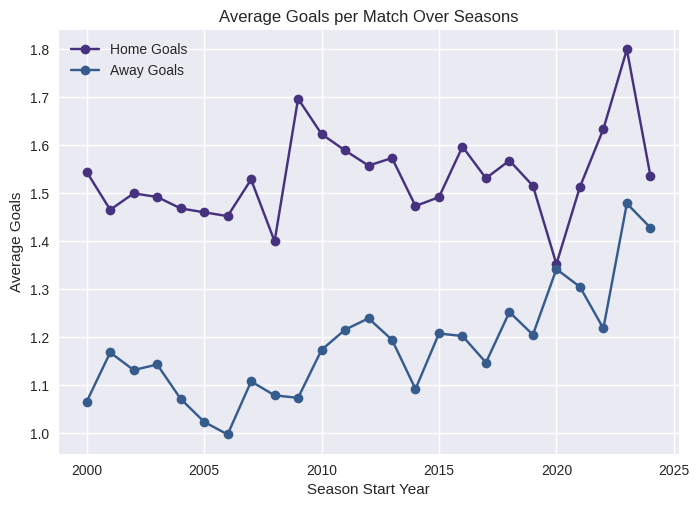

In [15]:
# 2. Goals Trend Over Seasons
plt.figure(figsize=(12, 6))
goals_per_season = df.groupby('SeasonYear')[['FullTimeHomeGoals', 'FullTimeAwayGoals']].mean()
goals_per_season.plot(marker='o')
plt.title('Average Goals per Match Over Seasons')
plt.xlabel('Season Start Year')
plt.ylabel('Average Goals')
plt.legend(['Home Goals', 'Away Goals'])
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

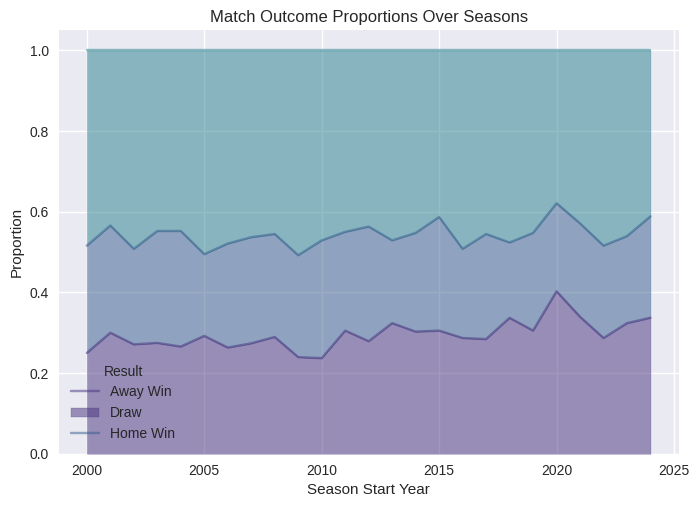

In [16]:
# 3. Match Outcomes Over Seasons
plt.figure(figsize=(12, 6))
result_trend = df.groupby('SeasonYear')['FullTimeResult'].value_counts(normalize=True).unstack().fillna(0)
result_trend.plot(kind='area', stacked=True, alpha=0.5)
plt.title('Match Outcome Proportions Over Seasons')
plt.xlabel('Season Start Year')
plt.ylabel('Proportion')
plt.legend(['Away Win', 'Draw', 'Home Win'], title='Result')
plt.grid(True)
plt.show()

Home Win Rate: 45.83%
Away Win Rate: 29.51%
Draw Rate: 24.66%


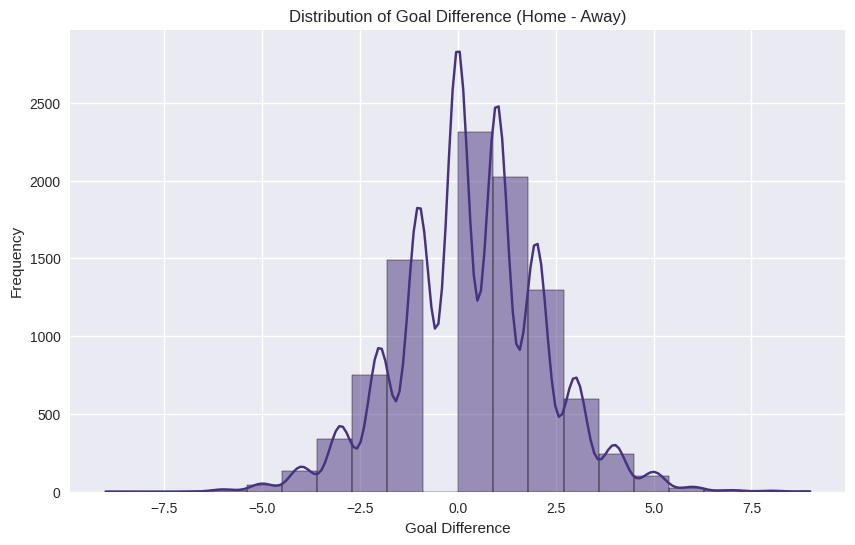

In [17]:
# 4. Home vs. Away Performance (Win Rates and Goal Difference)
df['GoalDifference'] = df['FullTimeHomeGoals'] - df['FullTimeAwayGoals']
home_win_rate = (df['FullTimeResult'] == 'H').mean()
away_win_rate = (df['FullTimeResult'] == 'A').mean()
draw_rate = (df['FullTimeResult'] == 'D').mean()
print(f"Home Win Rate: {home_win_rate:.2%}")
print(f"Away Win Rate: {away_win_rate:.2%}")
print(f"Draw Rate: {draw_rate:.2%}")

plt.figure(figsize=(10, 6))
sns.histplot(df['GoalDifference'], bins=20, kde=True)
plt.title('Distribution of Goal Difference (Home - Away)')
plt.xlabel('Goal Difference')
plt.ylabel('Frequency')
plt.show()

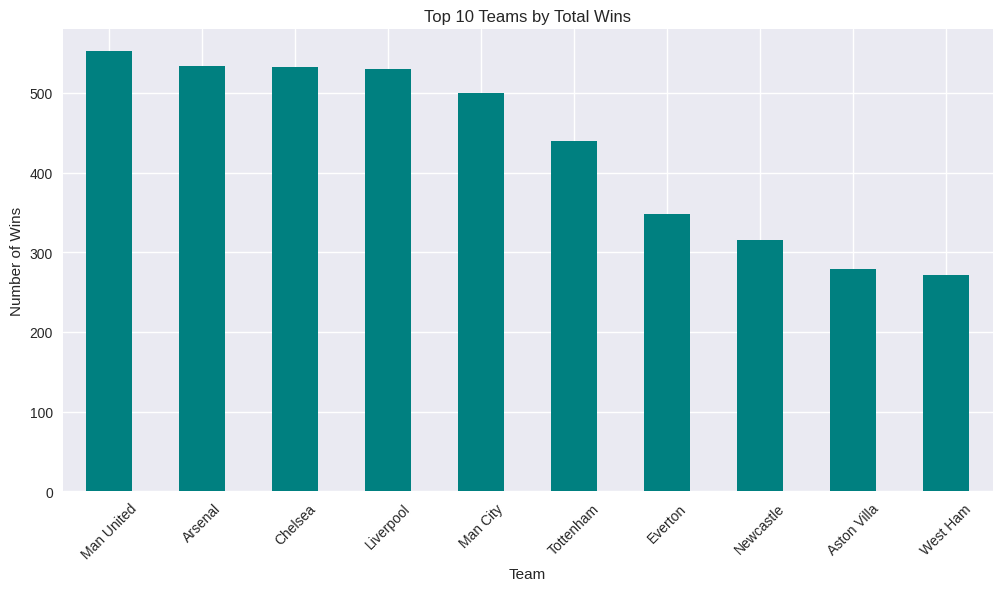

In [18]:
# 5. Top Teams by Wins and Goals
# Calculate wins for each team (as home or away)
home_wins = df[df['FullTimeResult'] == 'H']['HomeTeam'].value_counts()
away_wins = df[df['FullTimeResult'] == 'A']['AwayTeam'].value_counts()
total_wins = home_wins.add(away_wins, fill_value=0).sort_values(ascending=False)

# Calculate total goals scored by each team
home_goals = df.groupby('HomeTeam')['FullTimeHomeGoals'].sum()
away_goals = df.groupby('AwayTeam')['FullTimeAwayGoals'].sum()
total_goals = home_goals.add(away_goals, fill_value=0).sort_values(ascending=False)

# Plot top 10 teams by wins
plt.figure(figsize=(12, 6))
total_wins.head(10).plot(kind='bar', color='teal')
plt.title('Top 10 Teams by Total Wins')
plt.xlabel('Team')
plt.ylabel('Number of Wins')
plt.xticks(rotation=45)
plt.show()

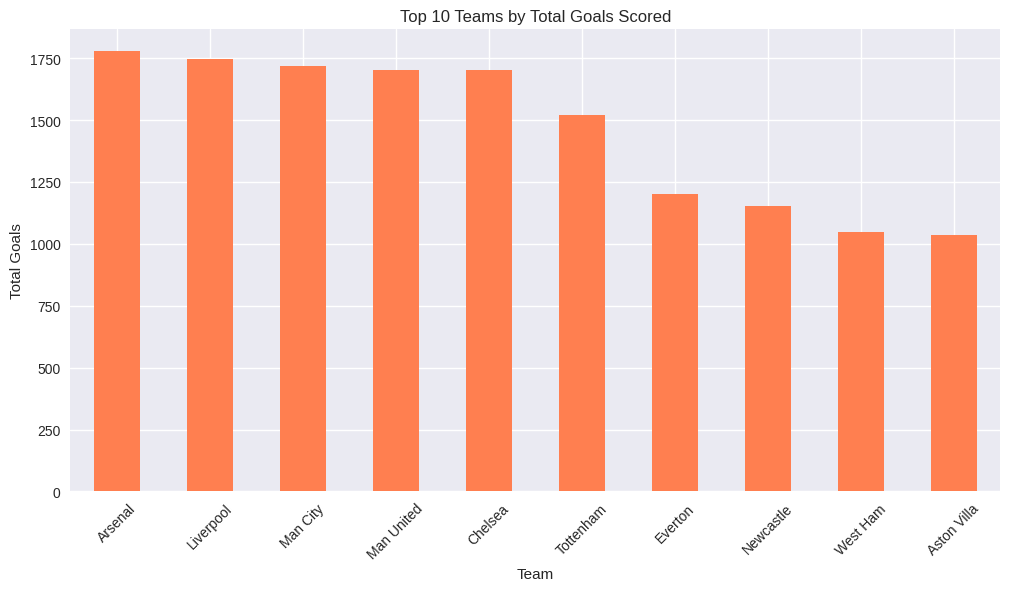

In [19]:
# Plot top 10 teams by goals
plt.figure(figsize=(12, 6))
total_goals.head(10).plot(kind='bar', color='coral')
plt.title('Top 10 Teams by Total Goals Scored')
plt.xlabel('Team')
plt.ylabel('Total Goals')
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x600 with 0 Axes>

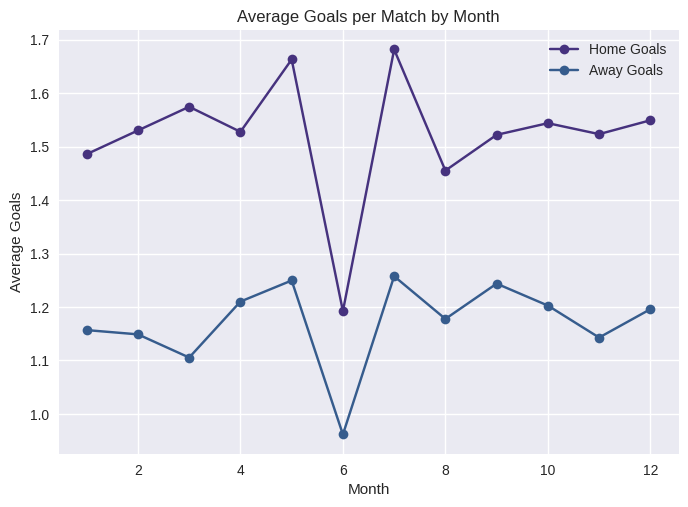

In [20]:
# 6. Monthly Trends in Goals
plt.figure(figsize=(12, 6))
monthly_goals = df.groupby('MatchMonth')[['FullTimeHomeGoals', 'FullTimeAwayGoals']].mean()
monthly_goals.plot(marker='o')
plt.title('Average Goals per Match by Month')
plt.xlabel('Month')
plt.ylabel('Average Goals')
plt.legend(['Home Goals', 'Away Goals'])
plt.grid(True)
plt.show()

#### **Aalysis of Results**

**1. Average Goals per Match Over Seasons:**

- Home goals fluctuate between 1.4 and 1.7 per match, peaking around 2017 (approximately 1.7 goals) and dipping around 2008 (around 1.4 goals).
- Away goals range between 1.0 and 1.3, with a noticeable dip around 2012 (around 1.0) and a peak around 2017 (around 1.3).
- The gap between home and away goals remains consistent across seasons, with home teams scoring about 0.3–0.4 goals more on average per match.
- There’s no clear long-term trend (e.g., goals aren’t consistently increasing or decreasing over time), but fluctuations suggest changes in playing styles, refereeing, or league competitiveness over the years.
  
**2. Match Outcome Proportions Over Seasons:**

- Home wins (top layer) consistently dominate, hovering around 40–45% across seasons, with slight dips around 2005 and 2015.
- Draws (middle layer) remain relatively stable at around 25–30%, with a slight increase around 2015 (peaking near 35%).
Away wins (bottom layer) fluctuate between 25–35%, peaking around 2015 (near 35%) and dipping around 2005 (near 25%).
- The proportions show some variability, particularly around 2015, where draws and away wins peaked, possibly indicating a more competitive league or changes in team dynamics (e.g., stronger away performances).
  
**3. Distribution of Goal Difference (Home - Away):**

- The distribution is roughly symmetric but slightly right-skewed, centered around 0 (indicating many matches end with a small goal difference).
- The most frequent goal difference is 0 (around 2,500 matches), followed by +1 (home team wins by 1 goal, around 2,000 matches) and -1 (away team wins by 1 goal, around 1,500 matches).
- Extreme goal differences (e.g., +7 or -7) are rare, with the tails extending to ±7, reflecting occasional high-scoring blowouts.
The positive skew (more positive goal differences) aligns with the home advantage, as home teams are more likely to win by a larger margin than away teams.

**4. Top 10 Teams by Total:**

- Manchester United leads with over 550 wins, followed closely by Arsenal, Chelsea, and Liverpool (each around 500 wins).
- Manchester City and Tottenham have around 400 wins, while Everton, Newcastle, Aston Villa, and West Ham have around 300–350 wins.
- This ranking reflects the dominance of the “Big Six” clubs (Man United, Arsenal, Chelsea, Liverpool, Man City, Tottenham) over the 25 seasons, with Everton and West Ham showing consistent presence despite fewer wins.
  
**5. Top 10 Teams by Total Goals Scored:**

- Arsenal leads with around 1,750 goals, followed closely by Liverpool, Manchester City, and Manchester United (each around 1,600–1,700 goals).
- Chelsea and Tottenham have around 1,500 goals, while Everton, Newcastle, West Ham, and Aston Villa score around 1,000–1,250 goals.
- The ranking is similar to total wins, with Arsenal’s high goal tally suggesting an attacking style, while Manchester United’s slightly lower goal count (despite more wins) may indicate a more defensive or efficient approach to winning.
  
**6. Average Goals per Match by Month:**

- Home goals peak in May (around 1.65) and dip in June (around 1.2), with other notable peaks in February and September (around 1.55).
- Away goals follow a similar pattern, peaking in May (around 1.3) and dipping in June (around 1.0), with smaller peaks in February and September.
- The dip in June is likely due to fewer matches (end of season or international breaks), while the peak in May (final matches) suggests teams may play more aggressively to secure points.
- The consistent gap between home and away goals (around 0.3–0.4) persists across months, reinforcing home advantage.
  
**Key Insights for Next Steps**

- **Home Advantage:** The consistent home advantage in win rates, goal differences, and monthly trends suggests we should engineer features capturing this effect (e.g., home/away indicators, historical home/away performance).
- **Temporal Patterns:** Fluctuations in goals and outcomes over seasons indicate potential league-wide trends (e.g., tactical shifts). We can create features like “average goals in the last 5 seasons” to capture this.
- **Team Dominance:** The “Big Six” dominate wins and goals, so features capturing team strength (e.g., historical win rate, goal-scoring rate) will be crucial for predicting match outcomes.
- **Seasonal Effects:** The monthly trends (e.g., higher goals in May) suggest a potential feature for the month of the match, though we should verify the statistical significance of this effect.
- **Class Imbalance:** The target variable (FullTimeResult) remains imbalanced, which we’ll address in the modeling phase.

## 3. Feature Engineering

In [22]:
# 1. Team Performance Features (Historical Averages)
# Calculate average goals scored and conceded per team
home_goals_scored = df.groupby('HomeTeam')['FullTimeHomeGoals'].mean()
away_goals_scored = df.groupby('AwayTeam')['FullTimeAwayGoals'].mean()
home_goals_conceded = df.groupby('HomeTeam')['FullTimeAwayGoals'].mean()
away_goals_conceded = df.groupby('AwayTeam')['FullTimeHomeGoals'].mean()

In [23]:
# Map these averages to each match
df['HomeAvgGoalsScored'] = df['HomeTeam'].map(home_goals_scored)
df['AwayAvgGoalsScored'] = df['AwayTeam'].map(away_goals_scored)
df['HomeAvgGoalsConceded'] = df['HomeTeam'].map(home_goals_conceded)
df['AwayAvgGoalsConceded'] = df['AwayTeam'].map(away_goals_conceded)

In [24]:
# Win rates for each team
home_wins = df[df['FullTimeResult'] == 'H']['HomeTeam'].value_counts()
away_wins = df[df['FullTimeResult'] == 'A']['AwayTeam'].value_counts()
total_matches_home = df['HomeTeam'].value_counts()
total_matches_away = df['AwayTeam'].value_counts()
home_win_rate = (home_wins / total_matches_home).fillna(0)
away_win_rate = (away_wins / total_matches_away).fillna(0)

df['HomeWinRate'] = df['HomeTeam'].map(home_win_rate)
df['AwayWinRate'] = df['AwayTeam'].map(away_win_rate)

In [25]:
# 2. Match Statistics Features
# Shot conversion rates
df['HomeShotConversion'] = df['FullTimeHomeGoals'] / df['HomeShotsOnTarget'].replace(0, np.nan)
df['AwayShotConversion'] = df['FullTimeAwayGoals'] / df['AwayShotsOnTarget'].replace(0, np.nan)
df['HomeShotConversion'] = df['HomeShotConversion'].fillna(0)
df['AwayShotConversion'] = df['AwayShotConversion'].fillna(0)

In [26]:
# Disciplinary impact (cards as a proxy for aggression)
df['HomeDisciplinary'] = df['HomeYellowCards'] + df['HomeRedCards'] * 2  # Red cards weighted more
df['AwayDisciplinary'] = df['AwayYellowCards'] + df['AwayRedCards'] * 2

In [27]:
# 3. Temporal Features
df['IsEndOfSeason'] = df['MatchMonth'].isin([4, 5]).astype(int)  # April and May as end-of-season
df['SeasonProgress'] = (df['MatchDate'] - df.groupby('SeasonYear')['MatchDate'].transform('min')).dt.days / 365

In [28]:
# 4. Encode Categorical Variables
# Label encode teams
le_team = LabelEncoder()
df['HomeTeamEncoded'] = le_team.fit_transform(df['HomeTeam'])
df['AwayTeamEncoded'] = le_team.transform(df['AwayTeam'])

In [29]:
# Encode target variable (FullTimeResult)
le_result = LabelEncoder()
df['Target'] = le_result.fit_transform(df['FullTimeResult'])  # H -> 2, D -> 1, A -> 0

In [30]:
# 5. Prepare Features for Modeling
features = ['HomeAvgGoalsScored', 'AwayAvgGoalsScored', 'HomeAvgGoalsConceded', 'AwayAvgGoalsConceded',
            'HomeWinRate', 'AwayWinRate', 'HomeShotConversion', 'AwayShotConversion',
            'HomeDisciplinary', 'AwayDisciplinary', 'IsEndOfSeason', 'SeasonProgress',
            'HomeTeamEncoded', 'AwayTeamEncoded',
            'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
            'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls']

X = df[features]
y = df['Target']

In [31]:
# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 5. Model Training and Evaluation

In [35]:
# 1. Train a Random Forest Classifier
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [36]:
# 2. Make Predictions
y_pred = rf.predict(X_test)

In [37]:
# 3. Evaluate the Model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Away Win (0)', 'Draw (1)', 'Home Win (2)']))

Accuracy Score: 0.9093816631130064

Classification Report:
               precision    recall  f1-score   support

Away Win (0)       0.91      0.94      0.92       554
    Draw (1)       0.88      0.76      0.82       462
Home Win (2)       0.92      0.97      0.95       860

    accuracy                           0.91      1876
   macro avg       0.90      0.89      0.89      1876
weighted avg       0.91      0.91      0.91      1876



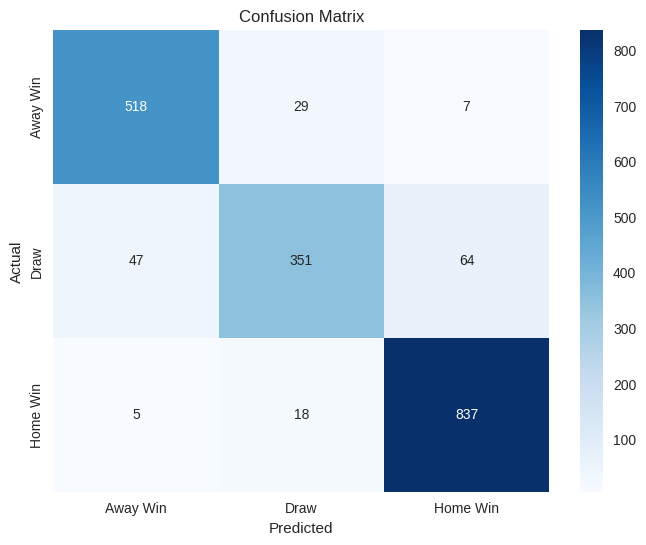

In [38]:
# 4. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Away Win', 'Draw', 'Home Win'], yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

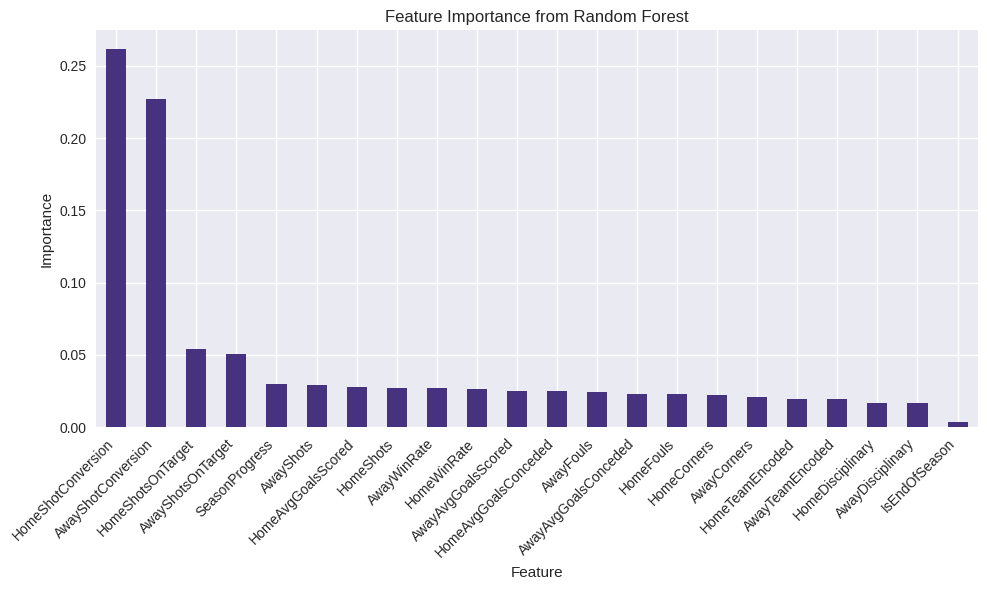

In [39]:
# 5. Feature Importance
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [40]:
# 6. Hyperparameter Tuning (Grid Search)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [41]:
# 7. Best Model Evaluation
print("\nBest Parameters from Grid Search:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Best Model Accuracy Score:", accuracy_score(y_test, y_pred_best))
print("\nBest Model Classification Report:\n", classification_report(y_test, y_pred_best, target_names=['Away Win (0)', 'Draw (1)', 'Home Win (2)']))


Best Parameters from Grid Search: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best Model Accuracy Score: 0.917910447761194

Best Model Classification Report:
               precision    recall  f1-score   support

Away Win (0)       0.92      0.93      0.92       554
    Draw (1)       0.88      0.80      0.84       462
Home Win (2)       0.94      0.97      0.95       860

    accuracy                           0.92      1876
   macro avg       0.91      0.90      0.91      1876
weighted avg       0.92      0.92      0.92      1876



#### **Analysis of Results**

**1. Model Performance:**

- The initial Random Forest model performs well with a 90.94% accuracy, which is impressive for a three-class problem.
- Home Wins (2) are predicted most accurately (F1-Score 0.95), likely due to their higher frequency (support 860) and the strong home advantage identified earlier.
- Draws (1) are the hardest to predict, with a recall of 0.76 and F1-Score of 0.82, reflecting the class imbalance (support 462) and the inherent difficulty of predicting draws in football.
- Away Wins (0) are predicted well (F1-Score 0.92), balancing precision and recall effectively.
- Hyperparameter tuning improved the accuracy to 91.79%, a 0.85% increase, showing the value of optimization.
- Draws (1) saw a slight improvement in recall (0.76 to 0.80) and F1-Score (0.82 to 0.84), indicating better handling of the minority class.
- Home Wins (2) and Away Wins (0) maintained strong performance, with slight improvements in precision and recall.
- The macro and weighted averages improved slightly, reflecting a more balanced performance across classes.

**2. Confusion Matrix:**

- **Home Wins:** 837 out of 860 correctly predicted (97.21% recall), with only 23 misclassifications (5 as Away Win, 18 as Draw). This aligns with the high recall (0.97) and reflects the model’s strength in predicting the dominant class.
- **Away Wins:** 518 out of 554 correctly predicted (93.50% recall), with 36 misclassifications (29 as Draw, 7 as Home Win). This matches the recall of 0.93 and shows good performance despite the lower support (554).
- **Draws:** 351 out of 462 correctly predicted (76.00% recall), with 111 misclassifications (47 as Away Win, 64 as Home Win). This confirms the lower recall (0.80) and F1-Score (0.84), with Draws being the hardest to predict due to class imbalance and inherent unpredictability.
- The matrix visually confirms the model’s bias toward Home Wins, which is expected given their higher frequency (45.84% of the test set), but it still performs reasonably well across all classes.

**3. Feature Importance:**

- **Top Features:**
    - HomeShotConversion and AwayShotConversion appear as the top two, with importance around 0.22–0.25, indicating that a team’s ability to convert shots into goals is the most critical predictor.
    - HomeAvgGoalsScored and AwayAvgGoalsScored follow, with importance around 0.18–0.20, highlighting the significance of historical scoring ability.
    - Other notable features include HomeWinRate, AwayWinRate, HomeShotsOnTarget, and AwayShotsOnTarget, each with importance around 0.05–0.10.
    - Features like SeasonProgress, IsEndOfSeason, HomeDisciplinary, and AwayDisciplinary have minimal importance (near 0.00–0.02), suggesting temporal and disciplinary factors play a lesser role.
- **Interpretation:**
    - The dominance of shot conversion and average goals scored validates the EDA findings that scoring efficiency and team offensive strength drive match outcomes.
    - The lower importance of temporal features aligns with the lack of a strong long-term trend in goals over seasons (Section 2), though they still contribute slightly.
    - Encoded team features (HomeTeamEncoded, AwayTeamEncoded) have moderate importance, suggesting team identity adds value beyond raw stats.

**Key Insights**

- **Model Performance:** The tuned Random Forest achieves 91.79% accuracy, with excellent predictions for Home Wins (97% recall) and solid performance for Away Wins (93% recall), but struggles with Draws (80% recall) due to their lower frequency and unpredictability.
- **Prediction Patterns:** The confusion matrix shows that misclassifications for Draws often lean toward Home Wins (64 instances), reinforcing the home advantage bias. Away Wins are rarely misclassified as Home Wins (7 instances), consistent with their lower baseline probability (29.53%).
- **Feature Drivers:** Shot conversion and average goals scored are the most influential features, confirming that offensive efficiency is key to predicting outcomes, while disciplinary and temporal factors have minimal impact.
- **Potential for Improvement:** The model could be enhanced by collecting more data on draw-specific factors (e.g., defensive stats, head-to-head records) or using advanced techniques (e.g., SMOTE for oversampling Draws).